In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import pickle

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.platform import tf_logging as logging
from tensorflow.keras.callbacks import Callback, EarlyStopping

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ih36sxb4 because the default path (/afs/cs.stanford.edu/u/mfchen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2022-10-24 18:21:17.355245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 18:21:17.355285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [48]:
N = 1000
s = 1

np.random.seed(s)
data = np.concatenate([np.random.normal(-1,0.2,N),np.random.normal(1,0.2,N)])
anomaly = np.concatenate([np.random.normal(-1.5,0.2,int(N*0.05)), np.random.normal(1.5,0.2,int(N*0.05))])
sim1 = np.concatenate([np.random.normal(0,1,N),np.random.normal(1,0.2,N)])
sim2 = np.concatenate([np.random.normal(-1,0.2,N),np.random.normal(0,1,N)])

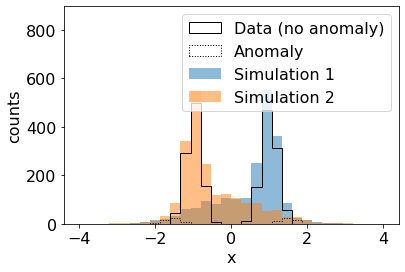

In [68]:
# Visualize data

n,b,_=plt.hist(data,bins=30,histtype="step",color="black", range=(-4, 4), label="Data (no anomaly)")
_,_,_=plt.hist(anomaly,bins=b,histtype="step",color="black",ls=":",label="Anomaly")
_,_,_=plt.hist(sim1,bins=b,alpha=0.5,label="Simulation 1")
_,_,_=plt.hist(sim2,bins=b,alpha=0.5,label = "Simulation 2")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x")
plt.ylabel("counts")

plt.savefig("./figs/salad_data_distr.pdf", bbox_inches='tight')

In [50]:
def split_data(x):
    n = x.shape[0]
    indices = np.random.permutation(n)

    indices_1 = indices[: int(n/2)]
    indices_2 = indices[int(n/2):]

    return x[indices_1], x[indices_2]

In [51]:
# shuffle and split each dataset into signal and sideband regions
#np.random.seed(42)

X_data_sb, X_data_sr = split_data(data)
X_sim1_sb, X_sim1_sr = split_data(sim1)
X_sim2_sb, X_sim2_sr = split_data(sim2)
anomaly_sb, anomaly_sr = split_data(anomaly)


n_data_sb, n_data_sr = X_data_sb.shape[0], X_data_sr.shape[0]
n_sim1_sb, n_sim1_sr = X_sim1_sb.shape[0], X_sim1_sr.shape[0]
n_sim2_sb, n_sim2_sr = X_sim2_sb.shape[0], X_sim2_sr.shape[0]
n_anomaly_sb, n_anomaly_sr = anomaly_sb.shape[0], anomaly_sr.shape[0]

In [52]:
#First, the models to reweight the simulation to the data

#sim 1 -> data
model_rw_sim1 = Sequential()
model_rw_sim1.add(Dense(32, input_dim=1, activation='relu'))
model_rw_sim1.add(Dense(32, activation='relu'))
model_rw_sim1.add(Dense(32, activation='relu'))
model_rw_sim1.add(Dense(1, activation='sigmoid'))
model_rw_sim1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 2 -> data
model_rw_sim2 = Sequential()
model_rw_sim2.add(Dense(32, input_dim=1, activation='relu'))
model_rw_sim2.add(Dense(32, activation='relu'))
model_rw_sim2.add(Dense(32, activation='relu'))
model_rw_sim2.add(Dense(1, activation='sigmoid'))
model_rw_sim2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1 + sim 2 -> data
model_rw_sim12 = Sequential()
model_rw_sim12.add(Dense(32, input_dim=1, activation='relu'))
model_rw_sim12.add(Dense(32, activation='relu'))
model_rw_sim12.add(Dense(32, activation='relu'))
model_rw_sim12.add(Dense(1, activation='sigmoid'))
model_rw_sim12.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#now, train classifiers to distinguish data (with anomaly) to simulation. 
#I'm assuming the interpolation to the signal region is exactly correct.

#sim 1 versus data
model_ad_sim1 = Sequential()
model_ad_sim1.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim1.add(Dense(32, activation='relu'))
model_ad_sim1.add(Dense(32, activation='relu'))
model_ad_sim1.add(Dense(1, activation='sigmoid'))
model_ad_sim1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1 (after reweigthing) versus data
model_ad_sim1_rw = Sequential()
model_ad_sim1_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim1_rw.add(Dense(32, activation='relu'))
model_ad_sim1_rw.add(Dense(32, activation='relu'))
model_ad_sim1_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim1_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 2 versus data
model_ad_sim2 = Sequential()
model_ad_sim2.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim2.add(Dense(32, activation='relu'))
model_ad_sim2.add(Dense(32, activation='relu'))
model_ad_sim2.add(Dense(1, activation='sigmoid'))
model_ad_sim2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 2 (after reweigthing) versus data
model_ad_sim2_rw = Sequential()
model_ad_sim2_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim2_rw.add(Dense(32, activation='relu'))
model_ad_sim2_rw.add(Dense(32, activation='relu'))
model_ad_sim2_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim2_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1+2 versus data
model_ad_sim12 = Sequential()
model_ad_sim12.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim12.add(Dense(32, activation='relu'))
model_ad_sim12.add(Dense(32, activation='relu'))
model_ad_sim12.add(Dense(1, activation='sigmoid'))
model_ad_sim12.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1+2 (after reweigthing) versus data
model_ad_sim12_rw = Sequential()
model_ad_sim12_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim12_rw.add(Dense(32, activation='relu'))
model_ad_sim12_rw.add(Dense(32, activation='relu'))
model_ad_sim12_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim12_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_ad_sim_multi_rw = Sequential()
model_ad_sim_multi_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim_multi_rw.add(Dense(32, activation='relu'))
model_ad_sim_multi_rw.add(Dense(32, activation='relu'))
model_ad_sim_multi_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim_multi_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# Construct data for first step

#sim 1 -> data: distinguish between data and simulation 1
x_vals_rw_sim1 = np.concatenate([X_data_sb, X_sim1_sb])
y_vals_rw_sim1 = np.concatenate([np.ones(len(X_data_sb)),np.zeros(len(X_sim1_sb))])
X_train_rw_sim1, X_val_rw_sim1, Y_train_rw_sim1, Y_val_rw_sim1 = train_test_split(x_vals_rw_sim1, y_vals_rw_sim1, random_state=42)

#sim 2 -> data: distinguish between data and simulation 2
x_vals_rw_sim2 = np.concatenate([X_data_sb, X_sim2_sb])
y_vals_rw_sim2 = np.concatenate([np.ones(len(X_data_sb)),np.zeros(len(X_sim2_sb))])
X_train_rw_sim2, X_val_rw_sim2, Y_train_rw_sim2, Y_val_rw_sim2 = train_test_split(x_vals_rw_sim2, y_vals_rw_sim2, random_state=42)

#sim 1+2 -> data: distinguish between data and simulation 1+2
x_vals_rw_sim12 = np.concatenate([X_data_sb, X_sim1_sb, X_sim2_sb])
y_vals_rw_sim12 = np.concatenate([np.ones(len(X_data_sb)),np.zeros(len(X_sim1_sb)),np.zeros(len(X_sim2_sb))])
X_train_rw_sim12, X_val_rw_sim12, Y_train_rw_sim12, Y_val_rw_sim12 = train_test_split(x_vals_rw_sim12, y_vals_rw_sim12, random_state=42)

In [54]:
myhistory_rw_sim1 = model_rw_sim1.fit(X_train_rw_sim1, Y_train_rw_sim1, epochs=100 ,batch_size=200,verbose=0)
print("Done with 1")
myhistory_rw_sim2 = model_rw_sim2.fit(X_train_rw_sim2, Y_train_rw_sim2, epochs=100 ,batch_size=200,verbose=0)
print("Done with 2")
myhistory_rw_sim12 = model_rw_sim12.fit(X_train_rw_sim12, Y_train_rw_sim12, epochs=100 ,batch_size=200,verbose=0)
print("Done with 1+2")

Done with 1
Done with 2
Done with 1+2


In [55]:
# Predictions on held-out set - let's look at if the reweighting is accurate
preds_val_rw_sim1 = model_rw_sim1.predict(X_val_rw_sim1,batch_size=1000)
preds_val_rw_sim2 = model_rw_sim2.predict(X_val_rw_sim2,batch_size=1000)
preds_val_rw_sim12 = model_rw_sim12.predict(X_val_rw_sim12,batch_size=1000)

1/1 [==============================] - 0s 85ms/step


In [56]:
matplotlib.rcParams.update({'font.size': 16})

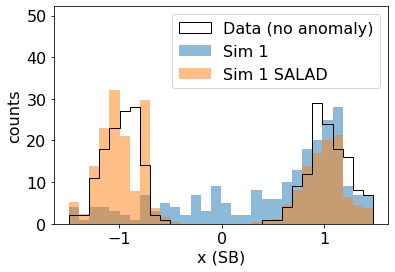

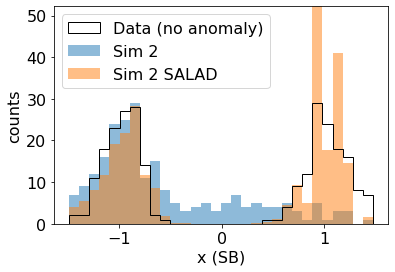

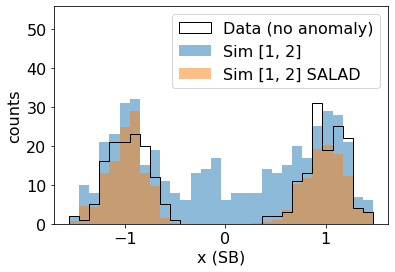

In [63]:
plt.figure()
n,b,_=plt.hist(X_val_rw_sim1[Y_val_rw_sim1==1],bins=30,histtype="step",color="black",label="Data (no anomaly)")
_,_,_=plt.hist(X_val_rw_sim1[Y_val_rw_sim1==0],bins=b,alpha=0.5,label="Sim 1")
_,_,_=plt.hist(X_val_rw_sim1[Y_val_rw_sim1==0],weights =preds_val_rw_sim1[Y_val_rw_sim1==0]/(1.-preds_val_rw_sim1[Y_val_rw_sim1==0]), bins=b,alpha=0.5,label="Sim 1 SALAD")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x (SB)")
plt.ylabel("counts")
plt.savefig("./figs/new_salad_1.pdf", bbox_inches='tight')

plt.figure()
n,b,_=plt.hist(X_val_rw_sim2[Y_val_rw_sim2==1],bins=30,histtype="step",color="black",label="Data (no anomaly)")
_,_,_=plt.hist(X_val_rw_sim2[Y_val_rw_sim2==0],bins=b,alpha=0.5,label="Sim 2")
_,_,_=plt.hist(X_val_rw_sim2[Y_val_rw_sim2==0],weights =preds_val_rw_sim2[Y_val_rw_sim2==0]/(1.-preds_val_rw_sim2[Y_val_rw_sim2==0]), bins=b,alpha=0.5,label="Sim 2 SALAD")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x (SB)")
plt.ylabel("counts")
plt.savefig("./figs/new_salad_2.pdf", bbox_inches='tight')

plt.figure()
n,b,_=plt.hist(X_val_rw_sim12[Y_val_rw_sim12==1],bins=30,histtype="step",color="black",label="Data (no anomaly)")
_,_,_=plt.hist(X_val_rw_sim12[Y_val_rw_sim12==0],bins=b,alpha=0.5,label="Sim [1, 2]")
_,_,_=plt.hist(X_val_rw_sim12[Y_val_rw_sim12==0],weights =preds_val_rw_sim12[Y_val_rw_sim12==0]/(1.-preds_val_rw_sim12[Y_val_rw_sim12==0]), bins=b,alpha=0.5,label="Sim [1, 2] SALAD")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x (SB)")
plt.ylabel("counts")
plt.savefig("./figs/new_salad_12.pdf", bbox_inches='tight')

In [58]:
#Now, for the classification models.

#sim 1 versus data
x_vals_ad_sim1 = np.concatenate([X_data_sr, anomaly_sr, X_sim1_sr])
y_vals_ad_sim1 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),np.zeros(len(X_sim1_sr))])
preds = model_rw_sim1.predict(X_sim1_sr,batch_size=1000).flatten()
w_vals_ad_sim1 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds/(1.-preds)])
X_train_ad_sim1, X_val_ad_sim1, Y_train_ad_sim1, Y_val_ad_sim1, W_train_ad_sim1, W_val_ad_sim1 = train_test_split(x_vals_ad_sim1, y_vals_ad_sim1, w_vals_ad_sim1, random_state=42)

#sim 2 versus data
x_vals_ad_sim2 = np.concatenate([X_data_sr,anomaly_sr,X_sim2_sr])
y_vals_ad_sim2 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),np.zeros(len(X_sim2_sr))])
preds = model_rw_sim2.predict(X_sim2_sr,batch_size=1000).flatten()
w_vals_ad_sim2 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds/(1.-preds)])
X_train_ad_sim2, X_val_ad_sim2, Y_train_ad_sim2, Y_val_ad_sim2, W_train_ad_sim2, W_val_ad_sim2 = train_test_split(x_vals_ad_sim2, y_vals_ad_sim2, w_vals_ad_sim2, random_state=42)

#sim 1+2 versus data
x_vals_ad_sim12 = np.concatenate([X_data_sr,anomaly_sr,X_sim1_sr,X_sim2_sr])
y_vals_ad_sim12 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),np.zeros(len(X_sim1_sr)),np.zeros(len(X_sim2_sr))])

preds12 = model_rw_sim12.predict(np.concatenate([X_sim1_sr, X_sim2_sr]),batch_size=1000).flatten()
w_vals_ad_sim12 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds12/(1.-preds12)])

preds1 = model_rw_sim1.predict(X_sim1_sr, batch_size=1000).flatten()
preds2 = model_rw_sim2.predict(X_sim2_sr, batch_size=1000).flatten()
preds_multi = np.concatenate([preds1, preds2])
w_vals_ad_sim_multi = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds_multi/(1.-preds_multi)])

X_train_ad_sim12, X_val_ad_sim12, Y_train_ad_sim12, Y_val_ad_sim12, W_train_ad_sim12, W_val_ad_sim12, W_train_ad_sim_multi, W_val_ad_sim_multi = train_test_split(x_vals_ad_sim12, y_vals_ad_sim12, w_vals_ad_sim12, w_vals_ad_sim_multi, random_state=42)

1/1 [==============================] - 0s 28ms/step


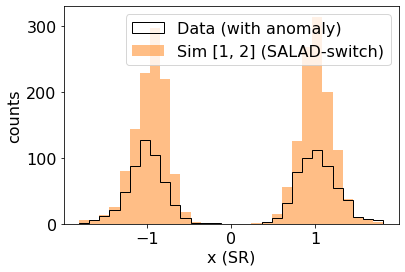

In [64]:
# weight_multi can blow things up due to high variance 
plt.figure()

n,b,_=plt.hist(x_vals_ad_sim12[y_vals_ad_sim12==1], histtype="step", color="black", bins=30,label="Data (with anomaly)")

_,_,_=plt.hist(x_vals_ad_sim12[y_vals_ad_sim12==0], weights=w_vals_ad_sim_multi[(w_vals_ad_sim_multi != 1) & (w_vals_ad_sim_multi != 0)], color="tab:orange", alpha=0.5,bins=b,label="Sim [1, 2] (SALAD-switch)")
plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
plt.savefig("./figs/new_salad_12_reweighting.pdf", bbox_inches='tight')


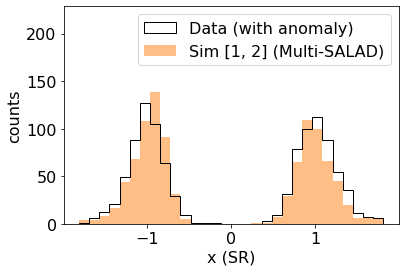

In [65]:
# weight_multi can blow things up due to high variance 
plt.figure()
n,b,_=plt.hist(x_vals_ad_sim12[y_vals_ad_sim12==1],histtype="step", color="black", bins=30,label="Data (with anomaly)")
_,_,_=plt.hist(x_vals_ad_sim12[y_vals_ad_sim12==0], weights=w_vals_ad_sim12[(w_vals_ad_sim12 != 1) & (w_vals_ad_sim12 != 0)], color="tab:orange", alpha=0.5,bins=b,label="Sim [1, 2] (Multi-SALAD)")
plt.ylim([0,max(n)*1.8])

plt.legend()
plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
plt.savefig("./figs/new_salad_multi_reweighting.pdf", bbox_inches='tight')


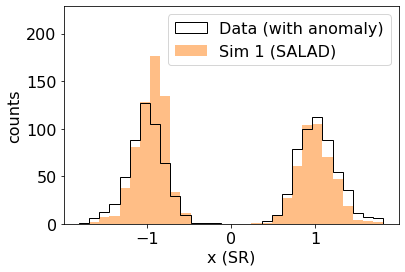

In [66]:
# weight_multi can blow things up due to high variance 
plt.figure()
n,b,_=plt.hist(x_vals_ad_sim1[y_vals_ad_sim1==1],histtype="step", color="black", bins=30,label="Data (with anomaly)")
_,_,_=plt.hist(x_vals_ad_sim1[y_vals_ad_sim1==0], weights=w_vals_ad_sim1[(w_vals_ad_sim1 != 1) & (w_vals_ad_sim1 != 0)], color="tab:orange", alpha=0.5,bins=b,label="Sim 1 (SALAD)")

plt.ylim([0,max(n)*1.8])

plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
plt.savefig("./figs/new_salad_1_reweighting.pdf", bbox_inches='tight')


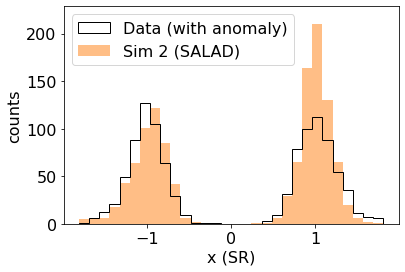

In [67]:
# weight_multi can blow things up due to high variance 
plt.figure()
n,b,_=plt.hist(x_vals_ad_sim2[y_vals_ad_sim2==1],histtype="step", color="black", bins=30,label="Data (with anomaly)")
_,_,_=plt.hist(x_vals_ad_sim2[y_vals_ad_sim2==0], weights=w_vals_ad_sim2[(w_vals_ad_sim2 != 1) & (w_vals_ad_sim2 != 0)], color="tab:orange", alpha=0.5,bins=b,label="Sim 2 (SALAD)")

plt.ylim([0,max(n)*1.8])

plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
plt.savefig("./figs/new_salad_2_reweighting.pdf", bbox_inches='tight')


In [785]:
myhistory_ad_sim1 = model_ad_sim1.fit(x_vals_ad_sim1, y_vals_ad_sim1, epochs=100 ,batch_size=200,verbose=0)
print("Done with 1")
myhistory_ad_sim1_rw = model_ad_sim1_rw.fit(x_vals_ad_sim1, y_vals_ad_sim1, sample_weight = w_vals_ad_sim1, epochs=100 ,batch_size=200,verbose=0)
print("Done with 1 rw")
myhistory_ad_sim2 = model_ad_sim2.fit(x_vals_ad_sim2, y_vals_ad_sim2, epochs=100 ,batch_size=200,verbose=0)
print("Done with 2")
myhistory_ad_sim2_rw = model_ad_sim2_rw.fit(x_vals_ad_sim2, y_vals_ad_sim2, sample_weight = w_vals_ad_sim2, epochs=100 ,batch_size=200,verbose=0)
print("Done with 2 rw")
myhistory_ad_sim12 = model_ad_sim12.fit(x_vals_ad_sim12, y_vals_ad_sim12, epochs=100 ,batch_size=200,verbose=0)
print("Done with 12")
myhistory_ad_sim12_rw = model_ad_sim12_rw.fit(x_vals_ad_sim12, y_vals_ad_sim12, sample_weight = w_vals_ad_sim12, epochs=100 ,batch_size=200,verbose=0)
print("Done with 12 rw")
myhistory_ad_sim_multi_rw = model_ad_sim_multi_rw.fit(x_vals_ad_sim12, y_vals_ad_sim12, sample_weight = w_vals_ad_sim_multi, epochs=50 ,batch_size=200,verbose=0)
print("Done with multi rw")

Done with 1
Done with 1 rw
Done with 2
Done with 2 rw
Done with 12
Done with 12 rw
Done with multi rw


In [786]:
# independent test set
class0 = np.concatenate([np.random.normal(-1,0.2,100000),np.random.normal(1,0.2,100000)])
class1 = np.concatenate([np.random.normal(-1.5,0.2,100000), np.random.normal(1.5,0.2,100000)])

In [787]:
from sklearn import metrics

In [788]:
golds = np.concatenate([np.ones(len(class1)),np.zeros(len(class0))])


In [789]:
scores0 = model_ad_sim1.predict(class0,batch_size=1000)
scores1 = model_ad_sim1.predict(class1,batch_size=1000)
all_scores = np.concatenate([scores1, scores0])
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(golds, all_scores)

acc1 = metrics.accuracy_score(golds, np.round(all_scores))
auc1 = metrics.roc_auc_score(golds, all_scores)
print("Unweighted on sim1:")
print(f"Accuracy: {acc1}")
print(f"AUC: {auc1}")


scores0_rw = model_ad_sim1_rw.predict(class0,batch_size=1000)
scores1_rw = model_ad_sim1_rw.predict(class1,batch_size=1000)
all_scores = np.concatenate([scores1_rw, scores0_rw])
fpr_1_rw, tpr_1_rw, thresholds_1_rw = metrics.roc_curve(golds, all_scores)
acc1_rw = metrics.accuracy_score(golds, np.round(all_scores))
auc1_rw = metrics.roc_auc_score(golds, all_scores)
print("Weighted on sim1:")
print(f"Accuracy: {acc1_rw}")
print(f"AUC: {auc1_rw}")


scores0_2 = model_ad_sim2.predict(class0,batch_size=1000)
scores1_2 = model_ad_sim2.predict(class1,batch_size=1000)
all_scores = np.concatenate([scores1_2, scores0_2])
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(golds, all_scores)
acc2 = metrics.accuracy_score(golds, np.round(all_scores))
auc2 = metrics.roc_auc_score(golds, all_scores)
print("Unweighted on sim2:")
print(f"Accuracy: {acc2}")
print(f"AUC: {auc2}")


scores0_2_rw = model_ad_sim2_rw.predict(class0,batch_size=1000)
scores1_2_rw = model_ad_sim2_rw.predict(class1,batch_size=1000)
all_scores = np.concatenate([scores1_2_rw, scores0_2_rw])
fpr_2_rw, tpr_2_rw, thresholds_2_rw = metrics.roc_curve(golds, all_scores)
acc2_rw = metrics.accuracy_score(golds, np.round(all_scores))
auc2_rw = metrics.roc_auc_score(golds, all_scores)
print("Weighted on sim2:")
print(f"Accuracy: {acc2_rw}")
print(f"AUC: {auc2_rw}")


scores0_12 = model_ad_sim12.predict(class0,batch_size=1000)
scores1_12 = model_ad_sim12.predict(class1,batch_size=1000)
all_scores = np.concatenate([scores1_12, scores0_12])
fpr_12, tpr_12, thresholds_12 = metrics.roc_curve(golds, all_scores)
acc12 = metrics.accuracy_score(golds, np.round(all_scores))
auc12 = metrics.roc_auc_score(golds, all_scores)
print("Unweighted on sim12:")
print(f"Accuracy: {acc12}")
print(f"AUC: {auc12}")

scores0_12_rw = model_ad_sim12_rw.predict(class0,batch_size=1000)
scores1_12_rw = model_ad_sim12_rw.predict(class1,batch_size=1000)
all_scores = np.concatenate([scores1_12_rw, scores0_12_rw])
fpr_12_rw, tpr_12_rw, thresholds_12_rw = metrics.roc_curve(golds, all_scores)
acc12_rw = metrics.accuracy_score(golds, np.round(all_scores))
auc12_rw = metrics.roc_auc_score(golds, all_scores)
print("Weighted on sim12 (multi):")
print(f"Accuracy: {acc12_rw}")
print(f"AUC: {auc12_rw}")


scores0_multi_rw = model_ad_sim_multi_rw.predict(class0, batch_size=1000)
scores1_multi_rw = model_ad_sim_multi_rw.predict(class1, batch_size=1000)
all_scores = np.concatenate([scores1_multi_rw, scores0_multi_rw])
fpr_multi_rw, tpr_multi_rw, thresholds_multi_rw = metrics.roc_curve(golds, all_scores)
acc_multi_rw = metrics.accuracy_score(golds, np.round(all_scores))
auc_multi_rw = metrics.roc_auc_score(golds, all_scores)
print("Weighted on sim12 (switch):")
print(f"Accuracy: {acc_multi_rw}")
print(f"AUC: {auc_multi_rw}")

200/200 [==============================] - 0s 2ms/step
Unweighted on sim1:
Accuracy: 0.4502025
AUC: 0.31396628403750004
200/200 [==============================] - 0s 1ms/step
Weighted on sim1:
Accuracy: 0.60666
AUC: 0.5018433093625
200/200 [==============================] - 0s 2ms/step
Unweighted on sim2:
Accuracy: 0.4477525
AUC: 0.29075566202500003
200/200 [==============================] - 0s 2ms/step
Weighted on sim2:
Accuracy: 0.6743925
AUC: 0.934437954525
200/200 [==============================] - 0s 2ms/step
Unweighted on sim12:
Accuracy: 0.5
AUC: 0.16639966325
200/200 [==============================] - 0s 1ms/step
Weighted on sim12 (multi):
Accuracy: 0.6003675
AUC: 0.9049115242875001
200/200 [==============================] - 0s 1ms/step
Weighted on sim12 (switch):
Accuracy: 0.5387675
AUC: 0.499815395875


/tmp/ipykernel_149405/3065060625.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_1_rw,1./fpr_1_rw,ls="-",color="tab:blue", label="Sim 1 SALAD")
/tmp/ipykernel_149405/3065060625.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_2_rw,1./fpr_2_rw,ls="-",color="tab:pink", label="Sim 2 SALAD")
/tmp/ipykernel_149405/3065060625.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_multi_rw,1./fpr_multi_rw,ls="-",color="tab:orange", label="SALAD-Switch", linewidth= 1.5)
/tmp/ipykernel_149405/3065060625.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_12_rw,1./fpr_12_rw,ls="-",color="tab:green", label="Multi-SALAD")


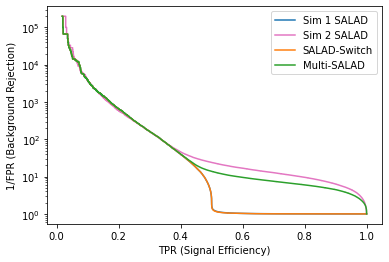

In [790]:
plt.plot(tpr_1_rw,1./fpr_1_rw,ls="-",color="tab:blue", label="Sim 1 SALAD")

plt.plot(tpr_2_rw,1./fpr_2_rw,ls="-",color="tab:pink", label="Sim 2 SALAD")

plt.plot(tpr_multi_rw,1./fpr_multi_rw,ls="-",color="tab:orange", label="SALAD-Switch", linewidth= 1.5)
plt.plot(tpr_12_rw,1./fpr_12_rw,ls="-",color="tab:green", label="Multi-SALAD")

plt.yscale("log")
plt.xlabel("TPR (Signal Efficiency)")
plt.ylabel("1/FPR (Background Rejection)")
plt.legend()

fname = "./figs/run_{}.pdf".format(s)

plt.savefig(fname)


In [793]:
fname = "new_run_{}.pkl".format(s)
with open(os.path.join("./data", fname), "wb") as fout:
    pickle.dump(
        {
            "tpr_1": tpr_1,
            "fpr_1": fpr_1,
            "tpr_1_rw": tpr_1_rw,
            "fpr_1_rw": fpr_1_rw,
            "tpr_2": tpr_2,
            "fpr_2": fpr_2,
            "tpr_2_rw": tpr_2_rw,
            "fpr_2_rw": fpr_2_rw,
            "tpr_12": tpr_12,
            "fpr_12": fpr_12,
            "tpr_12_rw": tpr_12_rw,
            "fpr_12_rw": fpr_12_rw,
            "tpr_multi_rw": tpr_multi_rw,
            "fpr_multi_rw": fpr_multi_rw,
            "acc1": acc1,
            "auc1": auc1,
            "acc1_rw": acc1_rw,
            "auc1_rw": auc1_rw,
            "acc2": acc2,
            "auc2": auc2,
            "acc2_rw": acc2_rw,
            "auc2_rw": auc2_rw,
            "acc12": acc12,
            "auc12": auc12,
            "acc12_rw": acc12_rw,
            "auc12_rw": auc12_rw,
            "acc_multi_rw": acc_multi_rw,
            "auc_multi_rw": auc_multi_rw
        },
        fout,
    )